### Basic Imports

In [2]:
# Import everything and setup things
import sys
import os
file_folder = os.getcwd()
if "testing_folder" in file_folder:
    file_folder = os.path.dirname(file_folder)
    sys.path.append(file_folder)
    os.chdir(file_folder)

import datetime
import math
import time
import json
from youtube_transcript_api import YouTubeTranscriptApi
import tiktoken
import faiss
import numpy as np
import asyncio
import ipywidgets
from IPython.display import display, HTML
import imp


keys=json.load(open("working_folder/keys.json"))

# Setup anthropic
import anthropic
anthropic_client = anthropic.Anthropic(api_key=keys["anthropic"])

# Setup openai
from openai import OpenAI
os.environ["OPENAI_API_KEY"]=keys["openai"]
openai_client = OpenAI(api_key=keys["openai"])

enc=tiktoken.get_encoding("cl100k_base")
input_cost=0
output_cost=0

C:\Users\ehlow\AppData\Local\Temp\ipykernel_26016\4161002909.py:21: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


### Import custom library or Reload for development

In [3]:
# import and reload custom functions 
import AiFunctions as af
imp.reload(af)

<module 'AiFunctions' from 'd:\\PROGRAMS\\DestinyFolder\\DestinyAIBot\\AiFunctions.py'>

## Designate Video ID for all subsequent processes https://vyneer.me/vods/

In [4]:
video_url="https://youtu.be/savIUlLu0MY"
# Set video id
#video_id="FC3giY7YDAQ"
#video_id="hkOI46Ai4g8"
video_id="YZuSc-EnI3o"

try:
    if video_url!="":
        video_id=video_url.split("/")[-1]
except:
    pass


### Load or Get transcript

In [5]:
# Get transcript and nearest times
transcript, nearest_times=af.load_or_get_transcript_info(video_id)
print(len(enc.encode(transcript)))

Loading transcript from file
101711


### Load or Make text chunks and vector_db for transcript search

In [6]:
vector_db, text_chunks_dict = await af.load_or_get_vectordb_and_chunks(openai_client, transcript, nearest_times, video_id)

Loading vector db from file
Loading text chunks from file


### Search Transcript

In [6]:
#load from text_chunks_dict
user_query=input("Enter your query: ")
print("Searching for:", user_query)

D, I=af.search_vector_db(openai_client, vector_db, user_query,5)

thtml=af.convert_to_html(nearest_times, video_id, text_chunks_dict[str(I[0][0])]["text"],text_chunks_dict[str(I[0][0])]["start"],I[0][0])
display(HTML(thtml))

Searching for: 


### Load or Create summarized segments

In [7]:
model_responses, run_input_cost, run_output_cost=await af.load_or_make_summarized_segments(anthropic_client, transcript, nearest_times, video_id, segments=1000)
input_cost+=run_input_cost
output_cost+=run_output_cost

Loading model responses from file


### Load or Make meta summary

In [8]:
meta_summary=af.load_or_make_meta_summary(anthropic_client, model_responses, video_id)

Loading meta summary from file


# Dev
### Chat processing

In [11]:
from chat_downloader import ChatDownloader

chat = ChatDownloader().get_chat(video_url)       # create a generator
c_count=0
all_chat_messages=[]
all_chat_messages_str=""
for message in chat:                        # iterate over messages
    #chat.print_formatted(message)   
    chat_message_formatted="User: "+message["author"]["name"] +", "+message["time_text"]+", Message: "+message["message"]
    all_chat_messages.append(chat_message_formatted)
    all_chat_messages_str+=chat_message_formatted+"\n"
    if c_count%100==0:
        print(chat_message_formatted) 
    c_count+=1
print(c_count)

# save chat string and messages
with open("working_folder/"+video_id+"/chat.txt","w", encoding='utf-8') as f:
    f.write(all_chat_messages_str)
json.dump(all_chat_messages,open("working_folder/"+video_id+"/chat.json","w"))
print("saved chat")

User: Aimsforgroin, 0:21, Message: W
User: GRUM, 3:01, Message: :_destinyDggL:wassup
User: The Jonavic, 6:18, Message: U_U
User: Raiders Cat⚔, 10:34, Message: @Jack come on man stop spamming:_destinyDaFeels:
User: Nacht, 14:55, Message: which Venti are we talking about?the huge-bust republican or the femboy from a video game?
User: Rick Montana, 19:41, Message: No room for two different split squats
User: Daniel Lastnaim, 23:08, Message: Yes it’s for Russification, they still genocide them first
User: NUCelusive1, 26:35, Message: except the numbers keep going up so it makes no sense
User: Grandaddy, 32:26, Message: i hate vyvanse cause i was force to take it as a kid
User: Cloudan, 36:33, Message: I was with Israel 100% but they’re really talking it too far now 
User: wintersun687, 39:45, Message: sussy
User: CharlieTheTurtle, 42:22, Message: @Destiny Why not have a look at the ICC case against Russia? I can't link it here
User: Alejandro Rodriguez, 47:03, Message: :_destinySweatstiny:

In [12]:
# load all chat messages
all_chat_messages=json.load(open("working_folder/"+video_id+"/chat.json"))

In [31]:
transcript_segment

{'bot': 'Here is a synopsis of the topics and sentiments expressed in the transcript:\n\nSuicide and Men\'s Mental Health:\n- The speaker (Destiny) agrees with Dr. K\'s viewpoint that many suicidal men are not clinically mentally ill, but rather feel their lives are not worth living due to their circumstances/outlook.\n- He expresses that this perspective comes from empathy and trying to understand their mindset, rather than immediately dismissing it as wrong.\n- He argues that much self-help content online just validates people\'s existing harmful behaviors rather than challenging them to improve.\n\nJordan Peterson:\n- Destiny believes Jordan Peterson was respected prior to his controversial takes around the C-16 bill.\n- He sees Peterson\'s clinical psychology practice as respectable, but dismisses his more recent cultural/political commentary as "garbage."\n\nOverall, the main sentiments are:\n1) Empathizing with perspectives you disagree with, rather than just dismissing them.\n2)

In [13]:
all_cm_str=""
for cm in all_chat_messages:
    all_cm_str+=cm+"\n"
print(len(enc.encode(all_cm_str)))

508145


In [13]:
# get chat segment for summary segment
transcript_segment=model_responses[5]

start_time=transcript_segment["start_second"]
end_time=transcript_segment["end_second"]



chats_in_segment=[]
chats_txt=""
chats_txt_numbered=""
chat_before_end=True
i=0
chat_num=0
while chat_before_end:
    try:
        # Get chat time
        chat_msg_time=all_chat_messages[i].split(",")[1].split(" ")[-1]
        if chat_msg_time.count(":")==1:
            chat_time=datetime.datetime.strptime(chat_msg_time, '%M:%S')
            chat_time=chat_time.minute*60+chat_time.second
        else:
            chat_time=datetime.datetime.strptime(chat_msg_time, '%H:%M:%S')
            chat_time=chat_time.hour*3600+chat_time.minute*60+chat_time.second
        
        if chat_time>end_time:
            chat_before_end=False
        elif chat_time>start_time:
            #print(all_chat_messages[i])
            chats_in_segment.append(all_chat_messages[i])
            chats_txt+=all_chat_messages[i]+"\n"
            chats_txt_numbered+=str(chat_num)+": "+all_chat_messages[i]+"\n"
            chat_num+=1
    except:
        pass
    i+=1
            

# # Get all chat messages in segment
# for i in range(len(all_chat_messages)):
#     try:
#         chat_msg_time=all_chat_messages[i].split(",")[1].split(" ")[-1]
#         if chat_msg_time.count(":")==1:
#             chat_time=datetime.datetime.strptime(chat_msg_time, '%M:%S')
#             chat_time=chat_time.minute*60+chat_time.second
#         else:
#             chat_time=datetime.datetime.strptime(chat_msg_time, '%H:%M:%S')
#             chat_time=chat_time.hour*3600+chat_time.minute*60+chat_time.second
#     except:
#         pass

#while 

In [33]:
print(chats_txt_numbered)

0: User: BabyElephant, 52:10, Message: Based
1: User: alpha, 52:11, Message: @
2: User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination 
3: User: franco D, 52:12, Message: :_destinySoy::face-red-droopy-eyes:
4: User: luc. tapia, 52:13, Message: come and see
5: User: BabyElephant, 52:14, Message: And yes 
6: User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
7: User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
8: User: Ivan, 52:17, Message: @
9: User: xxora, 52:20, Message: 20th century death toll dont even make sense
10: User: Jovos, 52:21, Message: @
11: User: Marc M, 52:24, Message: @TRON what's a king to a God!
12: User: TRON, 52:25, Message: @
13: User: chris lafond, 52:28, Message: who is gonna win the ncaa tourn

In [23]:
# Chat summary
bot_response=""
#chat_summary_prompt="You are meant to summarize serious messages in chat and get a general sentiment of the chat as well as pull out the repeated serious sentiments or serious questions or on topic messages. The user will give you all the chat messages with username\nMessage.\n\nYou will also be given the summary of the transcript of the livestream that the chat is facing which you can use to evalute who is on topic and better sense sentiment."

chat_summary_prompt="The user will give you a chat log and transcript summary over a certain period of a livestream and you will parse out serious chat messages. The chat message does not have to relate directly to the transcript but you must determine if it is serious or just banter or emotes. Try to include literally every single instance of a serious message." 

user_prompt="Here is the transcript summary: {transcript_summary}\n\nHere is the chat: {chat}\n\nGive me not some but every single serious message in the chat that I gave you."
f_user_prompt=user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)

print(len(enc.encode(f_user_prompt)))
proceed_str=input("Proceed with chat summary? (y/n)")
if proceed_str=="y":        
    with anthropic_client.messages.stream(
            max_tokens=4096,
            system=chat_summary_prompt,
            messages=[{"role":"user", "content": user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)}],
            model="claude-3-sonnet-20240229",
            #model="claude-3-haiku-20240307"
        ) as stream:
            for text in stream.text_stream:
                bot_response+=text
                print(text, end="", flush=True)
else:
    print("Process cancelled")

13234
Here are the serious messages I could find in the chat log:

User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination
User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
User: dean, 52:32, Message: @Destiny I remember you said that peace has to come with justice, I just want to clarify, Palestinian justice will never, ever happen. Israel won and Israel will dictate what will constitute peace.
User: dArcBIMer, 52:44, Message: my great uncle survived a stint in Katyn somehow... no tears for me team
User: Mo Fishin, 52:44, Message: Why isn't the starvation Hamass fault?  
User: Out of Context Politics, 54:45, Message: If Osama blamed all Americans for their government's

In [29]:
# Where
print(len(enc.encode(f_user_prompt)))
chat_query_prompt=" For each topic you are meant to pull out each individual comment that was mentioned to be related to that topic. You have to be thourough and make sure to map every single comment. Your response should be formatted simply with the User: username, Time: time, Message: message. EX:\nUser: username, Time: 1:23, Message: message\nUser: username, Time: 1:23, Message: message\nUser: username, Time: 1:23, Message: message\n..."
chat_query_response=""
if proceed_str=="y":        
    with anthropic_client.messages.stream(
            max_tokens=4096,
            system=chat_summary_prompt,
            #messages=[{"role":"user", "content": user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)}, {"role":"assistant", "content":bot_response},{"role":"user", "content": "Can you say which comments you are reffering to now? Mention what claim they support and their full message including username and time."}],
            messages=[{"role":"user", "content": user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)}, {"role":"assistant", "content":bot_response},{"role":"user", "content": "Can you group up the comments into categories. For each message copy it directly."}],
            #model="claude-3-sonnet-20240229",
            model="claude-3-haiku-20240307"
        ) as stream:
            for text in stream.text_stream:
                chat_query_response+=text
                print(text, end="", flush=True)
else:
    print("Process cancelled")

13234
Sure, I'll group the serious messages into the following categories:

Conflict and Warfare:
User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination
User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
User: IAM THAT, 54:37, Message: if Palestine launches indiscriminate rocket attacks for years daily on civilians centers, I'd Israel worse because it's weapon delivery in response is 500% more lethal?
User: Kalatiso, 1:01:46, Message: @Destiny I think the most comparable conflict to Gaza in history is probably Mosul or Fallujah in 2014, at least in the civilian and militant perspective.
User: IAM THAT, 1:01:17, Message: HAMAS did attack Bedouin arabs too. multiple death

In [20]:
# Where
print(len(enc.encode(f_user_prompt)))
chat_query_prompt=" For each topic you are meant to pull out each individual comment that was mentioned to be related to that topic. You have to be thourough."
chat_question_response=""

user_question=input("What is the question?")

if proceed_str=="y":        
    with anthropic_client.messages.stream(
            max_tokens=4096,
            system=chat_summary_prompt,
            messages=[{"role":"user", "content": user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)}, {"role":"assistant", "content":chat_query_response},{"role":"user", "content": user_question}],
            #model="claude-3-sonnet-20240229",
            model="claude-3-haiku-20240307"
        ) as stream:
            for text in stream.text_stream:
                chat_question_response+=text
                print(text, end="", flush=True)
else:
    print("Process cancelled")

13217
Yes, there are a couple other comments that raise similar points about comparing the Israeli-Palestinian conflict to other historical conflicts and urban warfare situations:

1. "Kalatiso, 53:08, Message: @Destiny Fallujah and Mosul are the closest in terms of civilian treatment"
   - This suggests comparing the situation in Gaza to the urban warfare in Fallujah and Mosul.

2. "Niklas, 53:22, Message: what about something like the siege of Warsaw?"
   - This proposes looking at the siege of Warsaw as an analogous historical situation.

So Confluence was not the only one to raise the idea of comparing the current conflict to other historical urban warfare or siege scenarios.

In [20]:
all_prev_yesses=[]

In [32]:
# Chats numbered identifier test


# Chat summary
chats_number_response=""
#chat_summary_prompt="You are meant to summarize serious messages in chat and get a general sentiment of the chat as well as pull out the repeated serious sentiments or serious questions or on topic messages. The user will give you all the chat messages with username\nMessage.\n\nYou will also be given the summary of the transcript of the livestream that the chat is facing which you can use to evalute who is on topic and better sense sentiment."

chat_summary_prompt="The user will give you a chat log and transcript summary over a certain period of a livestream and you will parse out serious chat messages. You will do this by going over each number and saying yes or no for each, yes if serious and no if not. Here is an example of the formatting for your response: 0: no-(a word 1 word description as to what it is)\n1: yes-(brief description)\n..." 

user_prompt="Here is the transcript summary: {transcript_summary}\n\nHere is the chat: {chat}\n\nThere are {number} chat messages and you must annotate all of them with yes or no."
#f_user_prompt=user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)

proceed_str=input("Proceed with chat summary? (y/n)")
if proceed_str=="y":        
    with anthropic_client.messages.stream(
            max_tokens=4096,
            system=chat_summary_prompt,
            messages=[{"role":"user", "content": user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt_numbered.split("100: ")[0],number=len(chats_in_segment))}],
            #model="claude-3-sonnet-20240229",
            model="claude-3-haiku-20240307",
            temperature=0.9
        ) as stream:
            for text in stream.text_stream:
                chats_number_response+=text
                print(text, end="", flush=True)
else:
    print("Process cancelled")

0: no-(casual chat)
1: no-(non-serious message)
2: yes-(discussing the German-Soviet conflict and the nature of their war)
3: no-(non-serious message)
4: no-(non-serious message)
5: no-(non-serious message)
6: yes-(discussing civilian deaths in the conflict)
7: yes-(asking about similar conflicts and analyzing numbers/ratios)
8: no-(non-serious message)
9: yes-(questioning the 20th century death toll statistics)
10: no-(non-serious message)
11: no-(non-serious message)
12: no-(non-serious message)
13: no-(asking about unrelated topic)
14: yes-(discussing the ideological nature of the German-Soviet conflict)
15: no-(non-serious message)
16: yes-(discussing the nature of dictatorships and high death tolls)
17: yes-(discussing the Israeli-Palestinian conflict and the prospects for justice)
18: yes-(continuing discussion about the German-Soviet conflict)
19: yes-(discussing the Imperial Japanese military strength)
20: yes-(discussing external funding and involvement in the conflict)
21: no

In [18]:
print(chats_txt_numbered.split("100: ")[0])

0: User: BabyElephant, 52:10, Message: Based
1: User: alpha, 52:11, Message: @
2: User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination 
3: User: franco D, 52:12, Message: :_destinySoy::face-red-droopy-eyes:
4: User: luc. tapia, 52:13, Message: come and see
5: User: BabyElephant, 52:14, Message: And yes 
6: User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
7: User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
8: User: Ivan, 52:17, Message: @
9: User: xxora, 52:20, Message: 20th century death toll dont even make sense
10: User: Jovos, 52:21, Message: @
11: User: Marc M, 52:24, Message: @TRON what's a king to a God!
12: User: TRON, 52:25, Message: @
13: User: chris lafond, 52:28, Message: who is gonna win the ncaa tourn

In [42]:
len(enc.encode(user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt_numbered.split("100: ")[0],number=len(chats_in_segment))))

3107

In [16]:
len(enc.encode(chats_number_response))

NameError: name 'chats_number_response' is not defined

In [15]:
len(all_chat_messages)

20375

In [33]:
# split out yeses and nos
chats_number_response_split=chats_number_response.split("\n")
yeses=[]
for i in range(len(chats_number_response_split)):
    if "yes-" in chats_number_response_split[i]:
        yeses.append(i)
print("Number of serious messages:", len(yeses))

all_prev_yesses.append(yeses)

Number of serious messages: 52


In [9]:
def print_aligned(lists):
    indices = [0] * len(lists)  # Initialize indices for each list
    max_lengths = [len(lst) for lst in lists]
    all_done = False

    while not all_done:
        current_values = []
        for i, lst in enumerate(lists):
            if indices[i] < max_lengths[i]:
                current_values.append((lst[indices[i]], i))
            else:
                current_values.append((float('inf'), i))  # Placeholder for completed lists
        
        min_value, _ = min(current_values, key=lambda x: x[0])  # Find next min value across lists
        
        for i, lst in enumerate(lists):
            if indices[i] < max_lengths[i] and lst[indices[i]] == min_value:
                print(f"{lst[indices[i]]:<4}", end='')  # Print value with padding
                indices[i] += 1  # Increment index for lists with the min value
            else:
                print("    ", end='')  # Print space (4 spaces here) for lists out of sync
        
        print()  # Newline after each round of printing
        
        all_done = all(indices[i] == max_lengths[i] for i in range(len(lists)))  # Check if all lists are done

# Example usage


print_aligned(all_prev_yesses)
#print_aligned(all_prev_yesses[0:3]+all_prev_yesses[4:])



ValueError: min() arg is an empty sequence

## Async analyze chat


In [20]:
print(chats_txt_numbered)

0: User: BabyElephant, 52:10, Message: Based
1: User: alpha, 52:11, Message: @
2: User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination 
3: User: franco D, 52:12, Message: :_destinySoy::face-red-droopy-eyes:
4: User: luc. tapia, 52:13, Message: come and see
5: User: BabyElephant, 52:14, Message: And yes 
6: User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
7: User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
8: User: Ivan, 52:17, Message: @
9: User: xxora, 52:20, Message: 20th century death toll dont even make sense
10: User: Jovos, 52:21, Message: @
11: User: Marc M, 52:24, Message: @TRON what's a king to a God!
12: User: TRON, 52:25, Message: @
13: User: chris lafond, 52:28, Message: who is gonna win the ncaa tourn

In [29]:
all_prev_yesses=[]

def yes_no_chat_analysis():
    # Chat summary
    chats_number_response=""
    #chat_summary_prompt="You are meant to summarize serious messages in chat and get a general sentiment of the chat as well as pull out the repeated serious sentiments or serious questions or on topic messages. The user will give you all the chat messages with username\nMessage.\n\nYou will also be given the summary of the transcript of the livestream that the chat is facing which you can use to evalute who is on topic and better sense sentiment."

    chat_summary_prompt="The user will give you a chat log and transcript summary over a certain period of a livestream and you will parse out serious chat messages. You will do this by going over each number and saying yes or no for each, yes if serious and no if not. Here is an example of the formatting for your response: 0: no-(a word 1 word description as to what it is)\n1: yes-(brief description)\n..." 
    
    # This prompt works
    chat_summary_prompt="The user will give you a chat log and transcript summary over a certain period of a livestream and you will parse out serious chat messages. You will do this by going over each number and saying yes or no for each, yes if serious and no if not. A serious message would be a statement of some kind, it can be a bit joke like but it should have substance instead of just being a very simple emoji or something. Here are examples of serious and not. Not serious: :eyes:, didnt say simon says! @@@@@@@@@@@@, @. Serious: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action, Make the ratio 15:2, Ehh the japans were pretty brutal. Here is an example of the formatting for your response: 0: no-(a word 1 word description as to what it is)\n1: yes-(brief description)\n..." 

    user_prompt="Here is the transcript summary: {transcript_summary}\n\nHere is the chat: {chat}\n\nThere are {number} chat messages and you must annotate all of them with yes or no."
    #f_user_prompt=user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt)

    proceed_str="y"#input("Proceed with chat summary? (y/n)")
    if proceed_str=="y":        
        with anthropic_client.messages.stream(
                max_tokens=4096,
                system=chat_summary_prompt,
                messages=[{"role":"user", "content": user_prompt.format(transcript_summary=transcript_segment["bot"], chat=chats_txt_numbered.split("100: ")[0],number=len(chats_in_segment))}],
                #model="claude-3-sonnet-20240229",
                model="claude-3-haiku-20240307",
                temperature=0.0
            ) as stream:
                for text in stream.text_stream:
                    chats_number_response+=text
                    #print(text, end="", flush=True)
    else:
        print("Process cancelled")

    # split out yeses and nos
    chats_number_response_split=chats_number_response.split("\n")
    yeses=[]
    for i in range(len(chats_number_response_split)):
        if "yes-" in chats_number_response_split[i]:
            yeses.append(i)
    print("Number of serious messages:", len(yeses))

    return yeses

def print_aligned(lists):
    indices = [0] * len(lists)  # Initialize indices for each list
    max_lengths = [len(lst) for lst in lists]
    all_done = False

    while not all_done:
        current_values = []
        for i, lst in enumerate(lists):
            if indices[i] < max_lengths[i]:
                current_values.append((lst[indices[i]], i))
            else:
                current_values.append((float('inf'), i))  # Placeholder for completed lists
        
        min_value, _ = min(current_values, key=lambda x: x[0])  # Find next min value across lists
        
        for i, lst in enumerate(lists):
            if indices[i] < max_lengths[i] and lst[indices[i]] == min_value:
                print(f"{lst[indices[i]]:<4}", end='')  # Print value with padding
                indices[i] += 1  # Increment index for lists with the min value
            else:
                print("    ", end='')  # Print space (4 spaces here) for lists out of sync
        
        print()  # Newline after each round of printing
        
        all_done = all(indices[i] == max_lengths[i] for i in range(len(lists))) 


async def thread_fetch():
    thread = await asyncio.to_thread(yes_no_chat_analysis)
    return(thread)


async def run_5_chat_analysis():

    responses = await asyncio.gather(*(thread_fetch() for i in range(8)))

    return responses
    #all_prev_yesses.append(await yes_no_chat_analysis())
    #print_aligned(all_prev_yesses)

prev_responses=responses
responses= await run_5_chat_analysis()
print_aligned(responses)

Number of serious messages: 46
Number of serious messages: 45
Number of serious messages: 46
Number of serious messages: 51
Number of serious messages: 49
Number of serious messages: 51
Number of serious messages: 50
Number of serious messages: 45
4   4   4   4   4   4   4   4   
    7   7   7   7               
8   8   8   8   8   8   8   8   
9   9   9   9   9   9   9   9   
11  11  11  11  11  11  11  11  
16  16  16  16  16  16  16  16  
18  18  18  18  18  18  18  18  
19  19  19  19  19  19  19  19  
20  20  20  20  20  20  20  20  
21  21  21  21  21  21  21  21  
22  22  22  22  22  22  22  22  
24  24  24  24  24  24  24  24  
26  26  26  26  26  26  26  26  
    28  28      28              
29  29  29  29  29  29  29  29  
32  32  32  32  32  32  32  32  
33  33  33  33  33  33  33  33  
34  34  34  34  34  34  34  34  
    37  37  37  37              
38  38  38  38  38  38  38  38  
40  40  40  40  40  40  40  40  
42  42  42  42  42  42  42  42  
43  43  43  43  43  43  43

In [30]:
print_aligned(responses+prev_responses)

                                2   2   2   2   2   2   2   2   
4   4   4   4   4   4   4   4                                   
                                5   5   5   5   5   5   5   5   
                                6   6   6   6   6   6   6   6   
    7   7   7   7               7   7   7   7   7   7   7   7   
8   8   8   8   8   8   8   8                                   
9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   
11  11  11  11  11  11  11  11                                  
                                14  14  14  14  14  14  14  14  
16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  
                                17  17  17  17  17  17  17  17  
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  
19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  
20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  
21  21  21  21  21  21  21  21                                  
22  22  22  22  22  22  2

In [27]:
prev_responses=responses

In [ ]:
Number of serious messages: 56
Number of serious messages: 56
Number of serious messages: 47
Number of serious messages: 50
Number of serious messages: 42
Number of serious messages: 50
Number of serious messages: 50
Number of serious messages: 47
    2               2   2       
4       4   4   4           4   
    6               6   6       
7   7       7       7   7       
8       8   8   8           8   
9   9   9   9   9   9   9   9   
11      11  11  11          11  
    14              14  14      
16  16  16  16  16  16  16  16  
    17              17  17      
18  18  18  18  18  18  18  18  
19  19  19  19  19  19  19  19  
20  20      20  20  20  20  20  
21      21  21  21          21  
22  22  22  22  22  22  22  22  
    23              23          
24  24      24  24  24  24  24  
26  26  26  26  26  26  26  26  
    27              27  27      
            28  28          28  
29      29  29  29          29  
    30              30  30      
    31              31  31      
32  32  32  32  32  32  32  32  
33      33  33  33          33  
34      34  34  34          34  
    35              35          
    36              36  36      
37                          37  
38  38  38  38  38  38  38  38  
40  40  40  40  40  40  40  40  
    41              41  41      
42  42  42  42  42  42  42  42  
43  43  43  43  43  43  43  43  
44      44  44  44          44  
45      45  45  45          45  
    47              47  47      
    48              48  48      
49      49  49  49          49  
50      50  50  50          50  
    56              56  56      
58  58  58  58  58          58  
    59              59  59  59  
    60              60  60      
61      61  61  61          61  
62  62  62  62  62  62  62  62  
    63              63  63      
64      64  64  64          64  
65  65  65  65  65  65  65  65  
67  67  67  67  67          67  
    68              68  68      
                            69  
70  70  70  70  70  70  70  70  
72  72  72  72  72      72  72  
74      74  74              74  
    75              75          
    76                          
77          77  77          77  
    78              78  78  78  
    79              79  79  79  
80  80  80  80  80  80  80  80  
81  81      81  81  81  81  81  
82      82  82  82          82  
83      83  83  83          83  
    84              84  84      
                            85  
86  86  86  86  86  86  86  86  
88  88  88  88  88  88  88  88  
    89              89          
90  90  90  90  90  90  90  90  
91          91                  
92  92  92  92  92  92  92  92  
    93              93  93      
94  94  94  94  94  94  94  94  
95  95  95  95  95  95  95  95  
96  96      96  96          96  
97      97  97  97          97  
    98                      98  
    99              99  99      
                            100 
101     101 101 101         101 


In [15]:
responses

[[2,
  5,
  6,
  7,
  9,
  14,
  16,
  17,
  18,
  19,
  20,
  22,
  24,
  26,
  27,
  30,
  31,
  32,
  35,
  36,
  38,
  40,
  41,
  42,
  43,
  47,
  48,
  56,
  59,
  60,
  62,
  63,
  65,
  68,
  70,
  72,
  75,
  78,
  79,
  80,
  81,
  84,
  86,
  88,
  89,
  90,
  92,
  93,
  94,
  95,
  99],
 [4,
  8,
  9,
  11,
  16,
  18,
  19,
  20,
  21,
  22,
  24,
  26,
  29,
  32,
  33,
  34,
  38,
  40,
  42,
  43,
  44,
  45,
  49,
  50,
  58,
  62,
  64,
  65,
  67,
  70,
  72,
  80,
  82,
  83,
  86,
  88,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  101]]

In [55]:
last_i_p=0
last_i_c=0
while True:
    if yeses[last_i_c]==prev_yeses[last_i_p]:
        print(yeses[last_i_c],prev_yeses[last_i_p])
        last_i_c+=1
        last_i_p+=1
    elif yeses[last_i_c]<prev_yeses[last_i_p]:
        print(yeses[last_i_c])
        last_i_c+=1
    else:
        print("  ",prev_yeses[last_i_p])
        last_i_p+=1
    

4 4
8 8
9 9
11 11
16 16
18 18
19 19
20 20
21 21
22 22
24 24
26 26
   28
29 29
32 32
33 33
34 34
   37
38 38
40 40
42 42
43 43
44 44
45 45
49 49
50 50
58 58
61 61
62 62
64 64
65 65
67 67
   69
70 70
72 72
   77
80 80
81 81
82 82
83 83
86 86
88 88
90 90
91
92 92
94 94
95 95
96 96
97 97
101 101


IndexError: list index out of range

In [17]:
prev_yeses=yeses

In [34]:
len(yeses)

51

In [33]:
overlap_2=[]
for y in yeses:
    if y in yeses_overlap:
        overlap_2.append(y)
    else:
        print(y)

    

2
6
7
14
17
27
30
31
35
36
41
47
48
56
59
60
63
68
75
76
78
79
84
93
98
99


In [40]:
for i in range(100):
    if i not in overlap_2:
        print(chats_in_segment[i])

User: BabyElephant, 52:10, Message: Based
User: alpha, 52:11, Message: @
User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination 
User: franco D, 52:12, Message: :_destinySoy::face-red-droopy-eyes:
User: luc. tapia, 52:13, Message: come and see
User: BabyElephant, 52:14, Message: And yes 
User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
User: Ivan, 52:17, Message: @
User: Jovos, 52:21, Message: @
User: Marc M, 52:24, Message: @TRON what's a king to a God!
User: TRON, 52:25, Message: @
User: chris lafond, 52:28, Message: who is gonna win the ncaa tournament?
User: TM, 52:30, Message: They were fighting over who was the superion socialist. 
User: luc. tapia, 52:31, Messa

In [39]:
for ol in overlap_2:
    print(chats_in_segment[ol])

User: xxora, 52:20, Message: 20th century death toll dont even make sense
User: abstrekt, 52:32, Message: Two dictators fighting against each other means a ton of people will die
User: Kalatiso, 52:34, Message: @Ivan that dint answer my question, in the war, what would have changed?
User: Jack, 52:34, Message: dont underestimate the imperial japanese
User: TheHolyLevant, 52:36, Message: Japan and China both were being funded by Adolf y'all should look up the 800 the 88th division of the NRA
User: Dudeman Bro, 52:39, Message: There’s pre-911 and post-911 and then there’s pre-vyvanse Destiny and post-vyvanse Destiny
User: xxora, 52:44, Message: france fought ww1 then ww2 the like a year late started wars in algeria and indochina that cost hundreds of thousands
User: dArcBIMer, 52:44, Message: my great uncle survived a stint in Katyn somehow... no tears for me team 
User: Cory Washburn, 52:54, Message: when I type in "soviets Nazis" on Google it tells me 1mil soviets collabed with Nazis
U

In [28]:
# compare prev_yeses to yeses
print(len(prev_yeses))
print(len(yeses))
total_off=0

yeses_overlap=[]
for i in range(len(yeses)):
    print(yeses[i], prev_yeses[i])

    if not yeses[i] in prev_yeses:
        #print(i)
        total_off+=1
    else:
        yeses_overlap.append(yeses[i])
print("T:",total_off)

50
51
2 4
6 8
7 9
9 11
14 16
16 18
17 19
18 20
19 21
20 22
22 24
24 25
26 26
27 29
30 32
31 33
32 34
35 38
36 40
38 42
40 43
41 44
42 45
43 49
47 50
48 58
56 61
59 62
60 64
62 65
63 67
65 69
67 70
68 72
70 74
75 77
76 80
78 81
79 82
80 83
81 86
84 88
86 90
88 92
90 94
92 95
93 96
95 97
96 100
98 101


IndexError: list index out of range

In [25]:
print(chats_txt_numbered.split("100: ")[0])

0: User: BabyElephant, 52:10, Message: Based
1: User: alpha, 52:11, Message: @
2: User: solainare wayzone, 52:12, Message:  German and soviets were fighting a complete war of extermination 
3: User: franco D, 52:12, Message: :_destinySoy::face-red-droopy-eyes:
4: User: luc. tapia, 52:13, Message: come and see
5: User: BabyElephant, 52:14, Message: And yes 
6: User: CharlieTheTurtle, 52:14, Message: @Destiny Keep in mind the starvations and other deaths not directly caused by militairy action
7: User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
8: User: Ivan, 52:17, Message: @
9: User: xxora, 52:20, Message: 20th century death toll dont even make sense
10: User: Jovos, 52:21, Message: @
11: User: Marc M, 52:24, Message: @TRON what's a king to a God!
12: User: TRON, 52:25, Message: @
13: User: chris lafond, 52:28, Message: who is gonna win the ncaa tourn

In [15]:
# print only if index is yes for chats in segment
chats_in_segment_yeses=[]
for i in range(len(chats_in_segment)):
    if i in yeses:
        chats_in_segment_yeses.append(chats_in_segment[i])
        print(chats_in_segment[i])

User: luc. tapia, 52:13, Message: come and see
User: Ivan, 52:17, Message: @
User: xxora, 52:20, Message: 20th century death toll dont even make sense
User: Marc M, 52:24, Message: @TRON what's a king to a God!
User: abstrekt, 52:32, Message: Two dictators fighting against each other means a ton of people will die
User: Kalatiso, 52:34, Message: @Ivan that dint answer my question, in the war, what would have changed?
User: Jack, 52:34, Message: dont underestimate the imperial japanese
User: TheHolyLevant, 52:36, Message: Japan and China both were being funded by Adolf y'all should look up the 800 the 88th division of the NRA
User: GRUM, 52:38, Message: :eyes:
User: Dudeman Bro, 52:39, Message: There’s pre-911 and post-911 and then there’s pre-vyvanse Destiny and post-vyvanse Destiny
User: xxora, 52:44, Message: france fought ww1 then ww2 the like a year late started wars in algeria and indochina that cost hundreds of thousands
User: no one, 52:44, Message: Japan had a hierarchy of who 

In [185]:
yeses

[2,
 6,
 7,
 9,
 14,
 16,
 17,
 18,
 19,
 20,
 22,
 24,
 26,
 27,
 30,
 31,
 32,
 35,
 36,
 38,
 40,
 41,
 42,
 43,
 47,
 48,
 56,
 59,
 60,
 62,
 63,
 65,
 67,
 68,
 70,
 72,
 75,
 78,
 79,
 80,
 81,
 84,
 86,
 88,
 90,
 92,
 93,
 94,
 95,
 99]

In [55]:
# create vector db of all the chat messages
structured_chat=[]
for c in chats_in_segment:
    user_name=c.split("User: ")[1].split(",")[0]
    time=c.split(", ")[1]
    message=c.split("Message: ")[1]
    structured_chat.append({"user_name":user_name, "time":time, "message":message})

In [57]:
# Async function to fetch embeddings
async def fetch_embeddings_async(text_chunks, model):
    model="text-embedding-3-large"
    async def fetch_embedding(chunk):
        # Simulate an async call to the embeddings API
        return await asyncio.to_thread(openai_client.embeddings.create, input=chunk, model=model)

    responses = await asyncio.gather(*(fetch_embedding(chunk["message"]) for chunk in text_chunks))
    embeddings = [response.data[0].embedding for response in responses]
    return np.array(embeddings)

# Generate embeddings
model="text-embedding-3-large"
embeddings=await fetch_embeddings_async(structured_chat, model)
print("Finished generating embeddings")

# Make vector db
vector_db=faiss.IndexFlatL2(embeddings.shape[1])
vector_db.add(np.array(embeddings))

Finished generating embeddings


In [91]:
chat_msg="Fallujah and Mosul are the closest in terms of civilian treatment"
chat_msg="@destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?"
sim_vector=af.search_vector_db(openai_client, vector_db, chat_msg,len(chats_in_segment))

In [92]:
chats_in_segment[sim_vector[1][0][2]]
sim_index=0
while sim_vector[0][0][sim_index]<1.25:
    print(sim_index, sim_vector[0][0][sim_index],chats_in_segment[sim_vector[1][0][sim_index]])
    sim_index+=1


0 9.094663e-06 User: Confluence, 52:15, Message: @destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?
1 0.61412776 User: Kalatiso, 1:01:46, Message: @Destiny I think the most comparable conflict to Gaza in history is probably Mosul or Fallujah in 2014, at least in the civilian and militant perspective.
2 0.99069816 User: Kalatiso, 53:08, Message: @Destiny Fallujah and Mosul are the closest in terms of civilian treatment
3 1.1031452 User: Jackspresso, 55:40, Message: Hey @destiny can you explain in simple terms what Genocide means and what does it has to do with the conflict?
4 1.1063919 User: Niklas, 53:22, Message: what about something like the siege of Warsaw?
5 1.1131105 User: Se7en Sinner, 53:14, Message: compare it to a conflict in fiction
6 1.1253664 User: Fitsum Yoseph, 1:00:39, Message: @Destiny at the start of conflict when Israel restricted access to water and electricity can th

In [95]:
index_id=0
sim_map=[]
for c in structured_chat:
    sim_vector=af.search_vector_db(openai_client, vector_db, c["message"],len(chats_in_segment))
    sim_index=0
    temp_sim_map=[]
    while sim_vector[0][0][sim_index]<1.25:
        #print(sim_index, sim_vector[0][0][sim_index],chats_in_segment[sim_vector[1][0][sim_index]])
        temp_sim_map
        sim_index+=1

    sim_map.append(sim_vector) 
    index_id+=1

0 {'user_name': 'BabyElephant', 'time': '52:10', 'message': 'Based'}
1 {'user_name': 'alpha', 'time': '52:11', 'message': '@'}
2 {'user_name': 'solainare wayzone', 'time': '52:12', 'message': ' German and soviets were fighting a complete war of extermination '}
3 {'user_name': 'franco D', 'time': '52:12', 'message': ':_destinySoy::face-red-droopy-eyes:'}
4 {'user_name': 'luc. tapia', 'time': '52:13', 'message': 'come and see'}
5 {'user_name': 'BabyElephant', 'time': '52:14', 'message': 'And yes '}
6 {'user_name': 'CharlieTheTurtle', 'time': '52:14', 'message': '@Destiny Keep in mind the starvations and other deaths not directly caused by militairy action'}
7 {'user_name': 'Confluence', 'time': '52:15', 'message': "@destiny, what's the most similar conflict to this? Is there any urban warfare situation that's analagous that we could look at numbers and ratios for?"}
8 {'user_name': 'Ivan', 'time': '52:17', 'message': '@'}
9 {'user_name': 'xxora', 'time': '52:20', 'message': '20th centur

In [98]:
from sklearn.cluster import DBSCAN

In [104]:
len(embeddings)

492

In [106]:
embeddings[0][0]

-0.0022102033253759146

In [170]:
0.9+85/500

1.07

In [171]:
dbscan = DBSCAN(eps=1.07, min_samples=2, metric='euclidean')
clusters = dbscan.fit_predict(embeddings)
# print number of items in dbscan with value >0
print(len(clusters[clusters>0]))

99 360


In [169]:
for i in range(100):
    dbscan = DBSCAN(eps=0.9+i/500, min_samples=2, metric='euclidean')
    clusters = dbscan.fit_predict(embeddings)
    # print number of items in dbscan with value >0
    print(i, len(clusters[clusters>0]))

0 178
1 178
2 179
3 183
4 187
5 189
6 192
7 194
8 194
9 194
10 194
11 197
12 197
13 197
14 197
15 197
16 201
17 203
18 203
19 206
20 208
21 208
22 208
23 209
24 211
25 213
26 214
27 216
28 217
29 220
30 223
31 225
32 226
33 226
34 229
35 231
36 232
37 237
38 239
39 239
40 241
41 241
42 242
43 242
44 246
45 250
46 254
47 257
48 258
49 260
50 264
51 270
52 273
53 275
54 277
55 285
56 287
57 290
58 293
59 295
60 300
61 302
62 303
63 306
64 306
65 308
66 313
67 317
68 323
69 326
70 328
71 328
72 330
73 333
74 334
75 337
76 337
77 338
78 342
79 344
80 347
81 350
82 351
83 357
84 359
85 360
86 360
87 360
88 362
89 364
90 367
91 360
92 361
93 363
94 365
95 115
96 112
97 58
98 48
99 48


In [172]:
clusters

array([ 0,  1,  2,  3, -1,  1,  3,  3,  1, -1,  1,  3,  1,  4, -1, -1,  2,
        3,  3,  5, -1,  3,  3, -1, -1,  5, -1,  3,  3,  3, -1,  5,  2,  4,
        3,  3,  3,  3,  3,  3,  3, -1,  3,  3,  3, -1,  3,  3,  3,  1,  1,
        1,  1,  3,  1,  1,  3,  6,  3,  3,  3,  1,  3,  3,  4,  3, -1, -1,
        3, -1,  3,  3, -1,  7,  3,  3, -1,  8,  3,  9, -1,  3, -1,  8,  3,
       -1,  3, -1,  3,  1, 10,  3,  3, -1, -1,  3,  3,  6,  3,  3,  3,  3,
        3, -1,  3,  3,  3, -1,  3,  3,  3, -1,  3,  3,  3,  1, -1,  3,  3,
       -1,  3,  3,  9, -1, -1,  3,  7,  9,  3, -1, -1, 11,  3,  3, -1, 10,
       11, 12,  3,  3, -1,  3,  3,  3,  3, 10,  4, -1, -1,  3, -1, -1, -1,
       13,  3, -1,  3,  3,  3, 10,  3,  3,  3,  1,  1,  3,  3, -1,  1,  3,
       14,  3,  3,  3,  1, 14, 14,  3, -1, 14,  3, -1,  3,  3, -1, -1, -1,
        3, -1,  3, 15,  3,  3, -1,  3,  3, -1, -1,  3, 15,  3, 11,  3,  3,
       -1,  3,  3,  3, -1, 16, -1, 10,  3, -1, -1, -1,  3, -1,  3,  3, 12,
        3,  3, 16, -1,  3

In [174]:
from collections import defaultdict

# Assuming `clusters` is the array of cluster labels from DBSCAN
# And `embeddings` is your array of embeddings

# Create a default dictionary to hold lists of embeddings
clustered_embeddings = defaultdict(list)

# Iterate over each of the cluster labels and embeddings
t_index=0
for cluster_label, embedding in zip(clusters, embeddings):
    t_index+=1
    # Skip noise points, which have a label of -1
    if (cluster_label != -1) and cluster_label!=0:
        clustered_embeddings[cluster_label].append(t_index)

# Convert defaultdict to a regular dict for further use if necessary
clustered_embeddings = dict(clustered_embeddings)

In [176]:
for key in list(clustered_embeddings.keys()):
    print(key)
    for v in clustered_embeddings[key]:
        print(structured_chat[v])
    print("\n\n\n")

1
{'user_name': 'solainare wayzone', 'time': '52:12', 'message': ' German and soviets were fighting a complete war of extermination '}
{'user_name': 'CharlieTheTurtle', 'time': '52:14', 'message': '@Destiny Keep in mind the starvations and other deaths not directly caused by militairy action'}
{'user_name': 'xxora', 'time': '52:20', 'message': '20th century death toll dont even make sense'}
{'user_name': 'Marc M', 'time': '52:24', 'message': "@TRON what's a king to a God!"}
{'user_name': 'chris lafond', 'time': '52:28', 'message': 'who is gonna win the ncaa tournament?'}
{'user_name': 'Totodile', 'time': '53:53', 'message': 'si'}
{'user_name': 'emperorhermitcrab', 'time': '53:54', 'message': 'No lmao'}
{'user_name': 'John William', 'time': '53:54', 'message': 'no'}
{'user_name': 'franco D', 'time': '53:54', 'message': ':thinking_face::thinking_face:'}
{'user_name': 'Entertainment', 'time': '53:55', 'message': 'nah'}
{'user_name': 'Hagbard', 'time': '53:57', 'message': 'its just terrori

In [149]:
# Get distance between embeddings[491] and embeddings[488]
np.linalg.norm(embeddings[449]-embeddings[460])

1.1578817524581422

In [138]:
structured_chat[151]

{'user_name': 'Mussard Lucien', 'time': '57:34', 'message': 'forsen'}

In [139]:
structured_chat[154]

{'user_name': 'itssowacc',
 'time': '57:45',
 'message': 'please watch the musk interview '}

In [113]:
len(clusters)

492

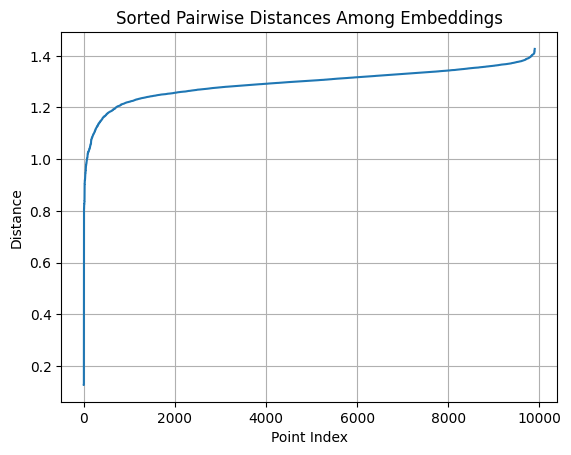

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Assuming `embeddings` is your full embeddings matrix
sample_embeddings = embeddings[np.random.choice(embeddings.shape[0], 100, replace=False)]  # Sample 1000 embeddings

# Compute the pairwise distances among the samples
distances = pdist(sample_embeddings, 'euclidean')
dist_matrix = squareform(distances)

# Sort the distances
sorted_distances = np.sort(dist_matrix, axis=None)

# Exclude the zero distance (distance of each point to itself)
sorted_distances = sorted_distances[sorted_distances > 0]

# Plot the sorted distances
plt.plot(sorted_distances)
plt.ylabel('Distance')
plt.xlabel('Point Index')
plt.title('Sorted Pairwise Distances Among Embeddings')
plt.grid(True)
plt.show()

# Look at the distribution and decide on an `eps`
